In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir("/content/drive/My Drive/UMass/CS685")

In [ ]:
# !pip install git+https://github.com/kteavery/transformers.git

In [ ]:
!pip install transformers
!pip install datasets
!pip install pytorch_pretrained_bert

     |████████████████████████████████| 3.3 MB 2.2 MB/s 
     |████████████████████████████████| 61 kB 445 kB/s 
     |████████████████████████████████| 596 kB 43.5 MB/s 
     |████████████████████████████████| 895 kB 47.6 MB/s 
     |████████████████████████████████| 3.3 MB 19.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 298 kB 2.3 MB/s 
     |████████████████████████████████| 132 kB 47.3 MB/s 
     |████████████████████████████████| 1.1 MB 43.3 MB/s 
     |████████████████████████████████| 243 kB 54.3 MB/s 
     |████████████████████████████████| 192 kB 41.0 MB/s 
     |████████████████████████████████| 271 kB 46.7 MB/s 
     |████████████████████████████████| 160 kB 71.2 MB/s 
     |████████████████████████████████| 123 kB 2.3 MB/s 
     |████████████████████████████████| 131 kB 15.8 MB/s 
     |████████████████████████████████| 8.4 

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AdamW, GPT2LMHeadModel, GPT2DoubleHeadsModel, GPT2TokenizerFast, GPT2Config, BertTokenizer

from transformers.modeling_outputs import CausalLMOutputWithCrossAttentions
from transformers.models.gpt2.modeling_gpt2 import GPT2DoubleHeadsModelOutput
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from pytorch_pretrained_bert.modeling_gpt2 import GPT2PreTrainedModel, GPT2MultipleChoiceHead, GPT2Model, GPT2LMHead, Attention, Block, \
    LayerNorm, MLP

In [ ]:
import os
import time
import datetime
# from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from datasets import load_dataset
med_dialog = load_dataset("medical_dialog", "en", data_dir="./Medical-Dialogue-Dataset-English")
covid_dialog = load_dataset("covid_qa_ucsd", "en", data_dir="./" )

Downloading:   0%|          | 0.00/3.82k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/913 [00:00<?, ?B/s]

Using custom data configuration en-7ad5e2a1147398cb


0 examples [00:00, ? examples/s]

Dataset medical_dialog downloaded and prepared to /root/.cache/huggingface/datasets/medical_dialog/en-7ad5e2a1147398cb/1.0.0/6b4b5348ad77903e71465d9910a30b9ec05dbeed9cb6b45349556a287ce42bab. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/3.49k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/805 [00:00<?, ?B/s]

Using custom data configuration en-data_dir=.%2F


0 examples [00:00, ? examples/s]

Dataset covid_qa_ucsd downloaded and prepared to /root/.cache/huggingface/datasets/covid_qa_ucsd/en-data_dir=.%2F/1.0.0/2a15b6e8fdc7cee91951d8f20ac2b26ede79fbef988919fbde22dbb97bf4df81. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
import pandas as pd

In [ ]:
cd_df = covid_dialog['train'].to_pandas()

In [ ]:
md_df = med_dialog['train'].to_pandas()

In [ ]:
print(md_df["dialogue_turns"])

0         {'speaker': [0, 1], 'utterance': ['Will mastur...
1         {'speaker': [0, 1], 'utterance': ['Could lack ...
2         {'speaker': [0, 1], 'utterance': ['What causes...
3         {'speaker': [0, 1], 'utterance': ['What cause ...
4         {'speaker': [0, 1], 'utterance': ['How to get ...
                                ...                        
229669    {'speaker': [0, 1], 'utterance': ['Q. Brother-...
229670    {'speaker': [0, 1], 'utterance': ['Q. Having o...
229671    {'speaker': [0, 1], 'utterance': ['Q. How long...
229672    {'speaker': [0, 1], 'utterance': ['Q. Tried wi...
229673    {'speaker': [0, 1], 'utterance': ['Q. How to r...
Name: dialogue_turns, Length: 229674, dtype: object


In [ ]:
print(cd_df["dialogue_turns"])

0      {'speaker': [0, 1, 0, 1], 'utterance': ['I hav...
1      {'speaker': [0, 1, 0, 1, 0, 1, 0, 1], 'utteran...
2      {'speaker': [0, 1], 'utterance': ['Can Coronav...
3      {'speaker': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...
4      {'speaker': [0, 1], 'utterance': ['Does COVID-...
                             ...                        
567    {'speaker': [0, 1], 'utterance': ['If I get co...
568    {'speaker': [0, 1], 'utterance': ['I was on a ...
569    {'speaker': [0, 1], 'utterance': ['My son has ...
570    {'speaker': [0, 1], 'utterance': ['Can coronav...
571    {'speaker': [0, 1], 'utterance': ['Good day,  ...
Name: dialogue_turns, Length: 572, dtype: object


In [ ]:
def processDialogue(cd_df, md_df):
  text = []
  augtext = []
  for dial in cd_df["dialogue_turns"]:
    u = dial["utterance"]
    for i in range(0,len(u),2):
      pq = u[i:i+2]
      p, q = u[i], u[i+1] 
      text.append(['<|endoftext|>'.join(pq)])
      augtext.append(['<|endoftext|>'.join(pq)])

  qa_df = pd.DataFrame(text, columns=["text"])

  for dial in md_df["dialogue_turns"]:
    u = dial["utterance"]
    for i in range(0,len(u), 2):
      pq = u[i:i+2]
      p, q = u[i], u[i+1]      
      if i % 100 == 0:
        augtext.append(['<|endoftext|>'.join(pq)])

  aug_qa_df = pd.DataFrame(augtext, columns=["text"])

  return qa_df, aug_qa_df

In [ ]:
qa_df, aug_qa_df,  = processDialogue(cd_df, md_df)

In [ ]:
print(len(aug_qa_df["text"]))

230257


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small", output_hidden_states = True)

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/641 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
class Baseline:
  def __init__(self, model, tokenizer, data):
    self.questionEmbeddingToAnswer = {}
    self.keysToQuestionEmb = {}
    self.model = model
    self.tokenizer = tokenizer
    self.tokenizer.pad_token = self.tokenizer.eos_token
    self.embeddings = []
    self.createQuestionEmbeddingToAnswer(data)
    self.neighbors = NearestNeighbors(n_neighbors=1, radius=0.4)
    print(torch.stack(self.embeddings).shape)
    self.neighbors.fit(torch.stack(self.embeddings))

  def getEmbedding(self, sentence):
    input_ids = tokenizer(sentence, max_length=32, truncation=True, padding="max_length", return_tensors='pt').input_ids
    return input_ids.squeeze()

  def createQuestionEmbeddingToAnswer(self, dataframe):
    count = 0
    for qa in dataframe:
      q, a = qa.split("<|endoftext|>")
      embedding = self.getEmbedding(q)
      self.questionEmbeddingToAnswer[count] = (q, a)
      self.embeddings.append(embedding)
      count += 1

  def findClosestKPairs(self, questionEmb):
    try: 
      id = self.neighbors.kneighbors(questionEmb, 1, return_distance=False)
    except Exception as err:
      print(err)

  def retrieveClosestAnswerGivenQuestion(self, input):
    # Given a question, return the answer associated to the closest question embedding
    kPairs = self.findClosestKPairs(input)
    
    

In [ ]:
b = Baseline(model, tokenizer, qa_df["text"])

torch.Size([583, 32])


In [ ]:
sample = tokenizer(aug_qa_df["text"][999],  max_length=32, truncation=True, padding="max_length", return_tensors='pt').input_ids

In [ ]:
sampleq, samplea = aug_qa_df["text"][999].split("<|endoftext|>")
print(sampleq)
print(samplea)
id = b.neighbors.kneighbors(sample, 1, return_distance=False)[0][0]
baselineq, baselinea = aug_qa_df["text"][id].split("<|endoftext|>")
print(baselineq)
print(baselinea)

Why do i feel i am loosing sensitivity in penis?hi sir, i feel like loosing my sensitivity in penis, there is nothing problem in urination. but my blood pressure has suddenly gone down because of weakness, and after that only i felt loosing my penis sensitiviy, and feeled lots of worries tension, and now i don't find erection seeing my gf, please advise
Hello,It may be due to performance anxiety. Still for further assessment you may require complete hemogram, lipid profile and electrocardiogram after physician consultation. Along with that Avoid stress and strenuous activity. Take balanced diet and proper rest. Avoid smoking and alcohol. Till then you can take tablet sildenafil one hour before sexual act Hope I have answered your query...Let me know if I can assist you further.Regards,Dr Shyam kaleFamily and general further
Do I just go to a Dr to determine if it's a sinus infection or do I go get tested for COVID first? To not risk anyone in practice?Do I just go to a Dr to determine 

In [ ]:
# Note: We may want to do prefix masked lm and not just generate the whole sequence
# We should probably truncate sequences on LHS
# It might also be good to split sentences with special doctor patient tokens.

In [ ]:
text = aug_qa_df.text.copy()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


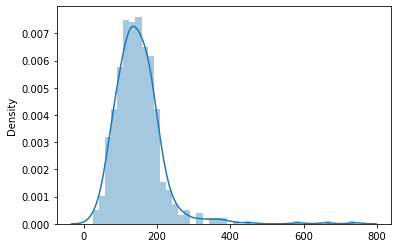

In [ ]:
doc_lengths = []

for bio in text:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)
             

In [ ]:
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small")
# tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-large-cased-v1.1')

In [ ]:
# if not tokenizer.eos_token :
#   tokenizer.eos_token = '<|endoftext|>' 

In [ ]:
batch_size = 2
tokenizer.pad_token = tokenizer.eos_token
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer(txt + tokenizer.eos_token, truncation=True, max_length=max_length, padding="max_length")
      
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [ ]:
dataset = GPT2Dataset(text, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  524 training samples
   59 validation samples


In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
)

In [ ]:
# I'm not really doing anything with the config buheret
# configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
# model = GPT2LMHeadModel.from_pretrained("microsoft/DialoGPT-small")
# model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
# if torch.cuda.is_available() and useCuda:
device = torch.device("cuda")
model.cuda()
# else:
#   device = torch.device("cpu")

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

RuntimeError: ignored

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100


In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))
    

In [ ]:
print(model.device)

In [ ]:
total_t0 = time.time()

training_stats = []

# model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
  
        model.zero_grad()        

        outputs = model(b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    # bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


In [ ]:
import pandas as pd
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats


In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    

In [ ]:
print(model.device)

print(bot_input_ids1.device)

print(chat_history_ids1.device)

# Can't be different

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './models/baseline-augmented/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


In [ ]:
ls

In [ ]:
!echo "pickles/" >> .gitignore

In [ ]:
!cat .gitignore

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("models/baseline-augmented")
model = AutoModelForCausalLM.from_pretrained("models/baseline-augmented")
model.to(device)

In [ ]:
model.eval()
step = 0
while True:
    context = input(">> User:")
    if context == "I am done talking":
      print("DoctorBot: Ok bye bye")
      break
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids1 = tokenizer(context + tokenizer.eos_token, return_tensors='pt').input_ids
    new_user_input_ids1 = new_user_input_ids1.to(device)
    # append the new user input tokens to the chat history
    bot_input_ids1 = torch.cat([chat_history_ids1, new_user_input_ids1], dim=-1) if step > 0 else new_user_input_ids1
    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids1 = model.generate(bot_input_ids1, max_length=1000, return_dict=True)
    print(type(chat_history_ids1))
    step += 1
    # pretty print last ouput tokens from bot
    print("DoctorBot: {}".format(tokenizer.decode(chat_history_ids1[:, bot_input_ids1.shape[-1]:][0], skip_special_tokens=True)))